In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
mpl.rc('font', size=12)

from numba import njit

# Voter model with mutation, coalescence approach

In [2]:
def get_4_neighbors(i, j, L):
    '''Finds upper, lower, left and right neighbor of a site in a K by K grid'''
    neighbors = []
    # Up, down, right, left
    directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]  
    for di, dj in directions:
        # Apply periodic boundary conditions
        neighbor_i = int((i + di) % L)
        neighbor_j = int((j + dj) % L)
        neighbors.append((neighbor_i, neighbor_j))
    return neighbors

In [3]:
import itertools

def moore_neighborhood_directions(R):
    # Find coordinates of all neighbors within range R
    directions = list(itertools.product(range(-R, R + 1), range(-R, R + 1)))
    del directions[int(len(directions)/2)]

    return directions

In [4]:
def get_9_neighbors(i, j, L, moore_directions):
    '''Finds all surrounding neighbors of a site in a L by L grid (Moore neighborhood)'''
    neighbors = []

    for di, dj in moore_directions:
        # Apply periodic boundary conditions
        neighbor_i = int((i + di) % L)
        neighbor_j = int((j + dj) % L)
        neighbors.append((neighbor_i, neighbor_j))
    return neighbors

In [5]:
import math

def get_neighbors_fattail(i, j, W, eta, moore_directions):
    ''' Computes fat-tailed dispersal kernel
    Parameters:
    - i: x-coordinate of center
    - j: y-coordinate of center
    - W: length scale or width of kernel
    - R: distance between parent and offspring
    - eta: defines "fatness" of the distribution

    Returns:
    - neighbors: list of all surrounding neighbors within range R
    - probabilities: list of all probabilities taken from a fat-tailed distribution given distance between center and neighbor
    '''

    neighbors = []
    probabilities = []

    # Find coordinates of neighbors within range R
    for di, dj in moore_directions:
        # Apply periodic boundary conditions
        neighbor_i = int((i + di) % W)
        neighbor_j = int((j + dj) % W)
        neighbors.append((neighbor_i, neighbor_j))

        # Calculate Euclidean distance between center and neighbor
        dist = math.dist([i, j], [neighbor_i, neighbor_j])

        # Calculate fat-tail probability
        K = ((eta + 2) / (2 * np.pi * W**2)) * (1 + ((dist)/W)**2 )**(eta/2)
        probabilities.append(K)
        
    probabilities = np.array(probabilities) / sum(probabilities)
    return neighbors, probabilities

In [6]:
from scipy import stats
from sklearn.metrics.pairwise import euclidean_distances

def get_neighbors_gaussian(i, j, W, moore_directions):
    ''' Computes Gaussian dispersal kernel
    Parameters:
    - i: x-coordinate of center
    - j: y-coordinate of center
    - W: length scale or width of kernel
    - R: distance between parent and offspring

    Returns:
    - neighbors: list of all surrounding neighbors within range R
    - probabilities: list of all probabilities taken from a Gaussian distribution given distance between center and neighbor
    '''

    neighbors = []
    probabilities = []

    # Find coordinates of all neighbors within range R
    for dir in moore_directions:
        neighbors.append(tuple(map(lambda x, y: (x + y) % W, dir, (i, j))))

    dist = euclidean_distances(neighbors, [[i,j]])
        
    for d in dist:
        probabilities.append(float(stats.norm.pdf(d, 0, 1)))
    
    probabilities = np.array(probabilities) / sum(probabilities)

    return neighbors, probabilities

In [13]:
def sa_curve(grid, n_centers):
    '''Calculates necessary data to construct species area curve
    Parameters:
    - grid (np array): 2d array of floats between 0 and 1, where each unique number represents a unique species
    - n_centers (int): Number of centers that the calculation is started from
    
    Returns:
    - areas (list): Contains areas that the amount of species were measured in
    - species (list of lists): Contains amount of unique species measured in each area in areas, n_centers times
    '''
    height, width = grid.shape
    # Create 3L by 3L version of grid, to avoid implementing periodic boundaries
    torus_grid = np.vstack((grid, grid, grid))
    torus_grid = np.hstack((torus_grid, torus_grid, torus_grid))
    
    n_centers = 10
    centers_x = np.random.choice(np.arange(0, width), n_centers) + width
    centers_y = np.random.choice(np.arange(0, height), n_centers) + height

    areas = []
    species = []
        
    for i, (x, y) in enumerate(zip(centers_x, centers_y)):
        cur_species = []
        for j in range(width//2):
            cur_species.append(len(np.unique(torus_grid[x-j:x+j+1, y-j:y+j+1])))
            if i == 0:
                areas.append((j+1)**2)
        species.append(cur_species)
    
    return areas, species

In [8]:
import random
import itertools
from tqdm import tqdm
import time
import sys

def voter_model_fast(L, alpha, kernel='nearest', W=3, eta=-1):
    '''Run experiment with the voter model
    Inputs:
    - L (int): Size of grid side
    - alpha (float): Value of alpha parameter, (speciation rate)
    - kernel (string): 'nearest', 'gaussian' or 'fat tail', depending on the type of kernel to be used
    - W (int): Size of dispersal kernel, only used with gaussian/fat tail kernel
    - eta (float/int): Value of eta parameter for the fat tail kernel.
    
    Returns:
    - species (list of sets): List of sets containing coordinates of sites in same species
    '''    
    rand_walkers = list(itertools.product(range(L), range(L)))

    # Create list to store number of unique species
    lineages = [set() for _ in range(len(rand_walkers))]
    for i, element in enumerate(rand_walkers):
        lineages[i].add(element)

    rand_walker_pos = rand_walkers.copy()
    species = []
    
    while len(rand_walker_pos) > 0:
        # Draw full list of random numbers to save time
        rand_nums = np.random.uniform(size=L**2)
        for j in tqdm(range(L**2)):
            if len(rand_walker_pos) == 0:             
                return species
            
            # Select active walker
            cur_walker_loc = np.random.choice(len(rand_walker_pos))
            cur_walker = rand_walker_pos[cur_walker_loc]
            # Find current walker's place in lineages
            cur_walker_idx = L*cur_walker[0] + cur_walker[1]

            if kernel in ['fat tail', 'gaussian', 'nearest_moore']:    
                moore_directions = moore_neighborhood_directions(W)
            
            # Select parent
            if kernel == 'nearest':
                potential_parents = get_4_neighbors(cur_walker[0], cur_walker[1], L)
                parent_walker_loc = np.random.choice(len(potential_parents))
                parent_walker = potential_parents[parent_walker_loc]
            elif kernel == 'gaussian':
                potential_parents, probabilities = get_neighbors_gaussian(cur_walker[0], cur_walker[1], W, moore_directions)
                parent_walker_loc = np.random.choice(len(potential_parents), p=probabilities)
                parent_walker = potential_parents[parent_walker_loc]
            elif kernel == 'fat tail':
                potential_parents, probabilities = get_neighbors_fattail(cur_walker[0], cur_walker[1], W, eta, moore_directions)
                parent_walker_loc = np.random.choice(len(potential_parents), p=probabilities)
                parent_walker = potential_parents[parent_walker_loc]
                
            # Find parent's place in lineages
            parent_walker_idx = L*parent_walker[0] + parent_walker[1]
            
            # Speciate with probability alpha
            speciate = False
            if rand_nums[j] < alpha:
                speciate = True
                species.append(lineages[cur_walker_idx])
                # Insert pointer to correct species where the walker is in
                for site in lineages[cur_walker_idx]:
                    site_idx = L*site[0] + site[1]
                    lineages[site_idx] = len(species) - 1                
            else:
                # Check if parent hasn't speciated yet
                if type(lineages[parent_walker_idx]) == set:
                    # Merge lineages if walkers are from other walks
                    if parent_walker not in lineages[cur_walker_idx]:
                        # Unify lineages of parent and child
                        lineages[cur_walker_idx] = lineages[cur_walker_idx].union(lineages[parent_walker_idx])
                        # Copy unified lienage to all sites in parent and child lineage
                        for site in lineages[cur_walker_idx]:
                            site_idx = L*site[0] + site[1]
                            lineages[site_idx] = lineages[cur_walker_idx]
                    # Handle case when walker has moved back into its own lineage
                    else:
                        # Change position of active walker
                        if parent_walker not in rand_walker_pos:
                            rand_walker_pos.append(parent_walker)
                # Let speciation occur
                elif type(lineages[parent_walker_idx]) == int:
                    species[lineages[parent_walker_idx]] = species[lineages[parent_walker_idx]].union(lineages[cur_walker_idx])
                    for site in lineages[cur_walker_idx]:
                        site_idx = L*site[0] + site[1]
                        lineages[site_idx] = lineages[parent_walker_idx]
            
            # Remove current walker from list of active walkers
            rand_walker_pos.remove(cur_walker)

    return species

In [10]:
import pickle
species_load = pickle.load(open(f"700x700,alpha=0.0001,kernel=nearest.p", "rb"))
species_ids = np.random.uniform(size=len(species_load))
print(len(species_load))

grid = np.zeros((700, 700))
for i, specie in enumerate(species_load):
    for coord in specie:
        grid[coord] = species_ids[i]

78


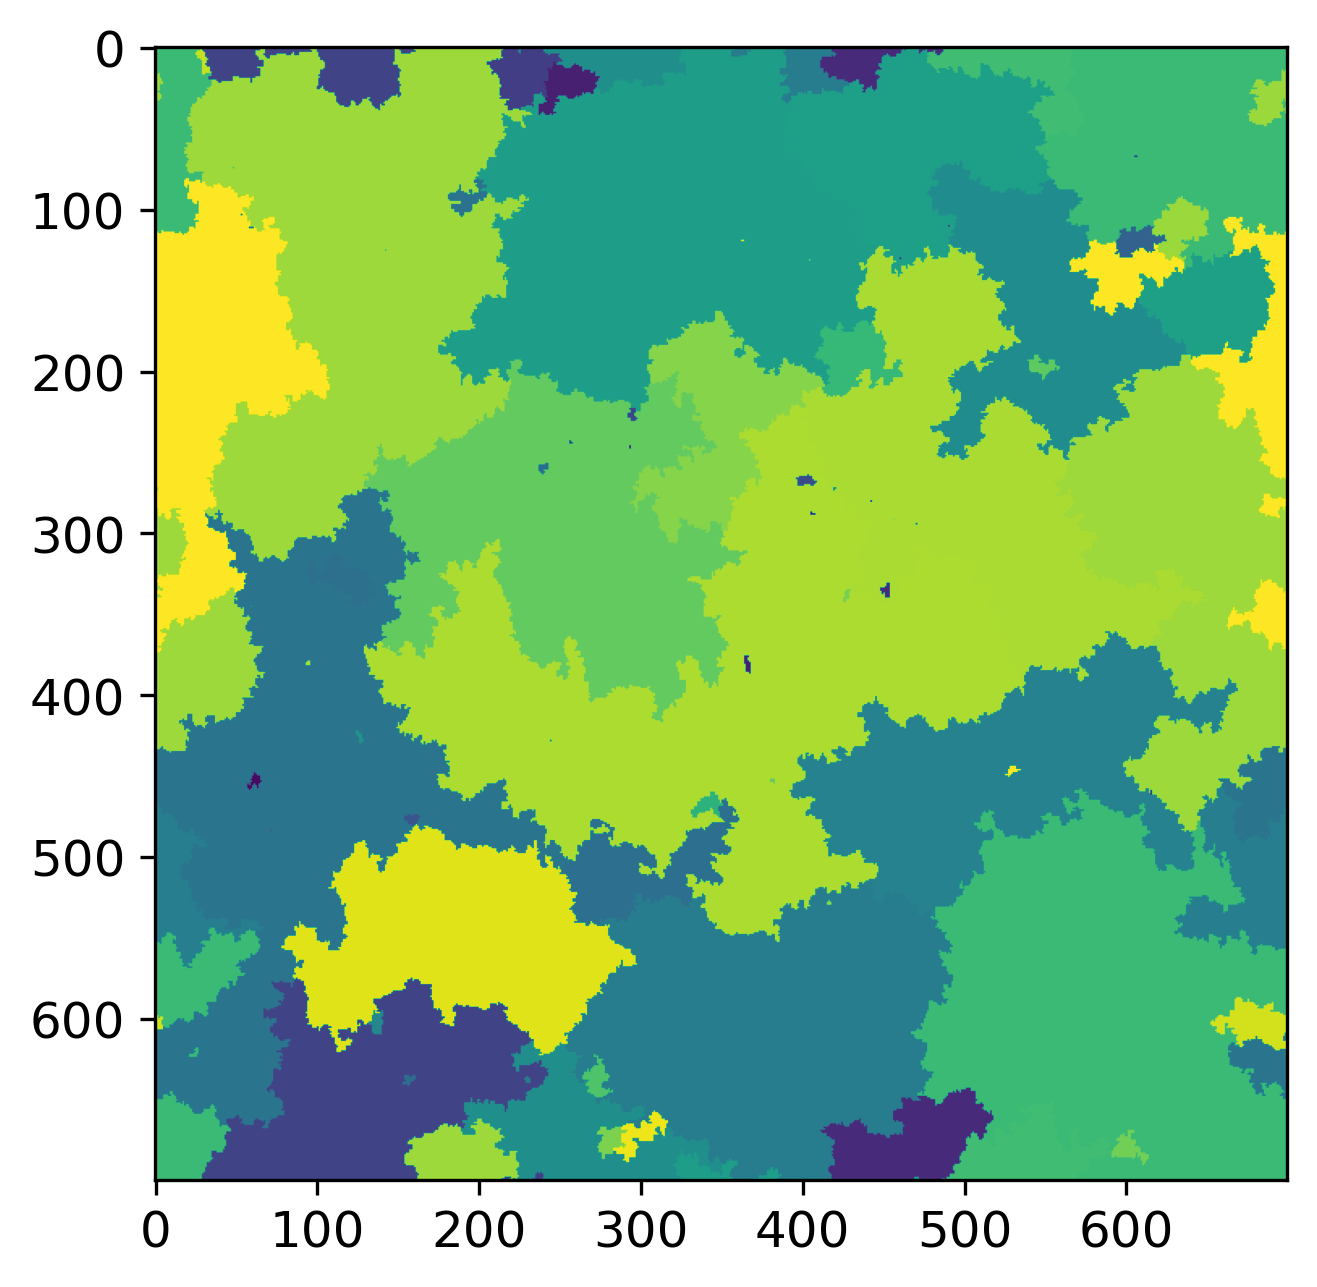

In [11]:
plt.figure(figsize=(5, 5))
plt.imshow(grid)
plt.show()

In [14]:
n_centers = 10

areas = []
num_species = []

grids = [grid]

for grid in grids:
    areas, cur_num_species = sa_curve(grid, n_centers)
    num_species = num_species + cur_num_species
    
spec_std_dev = np.std(num_species, axis=0)
spec_mean = np.mean(num_species, axis=0)

0.12844458229788272 0.9121305092990879
0.7124026045674551 0.018223285132675467


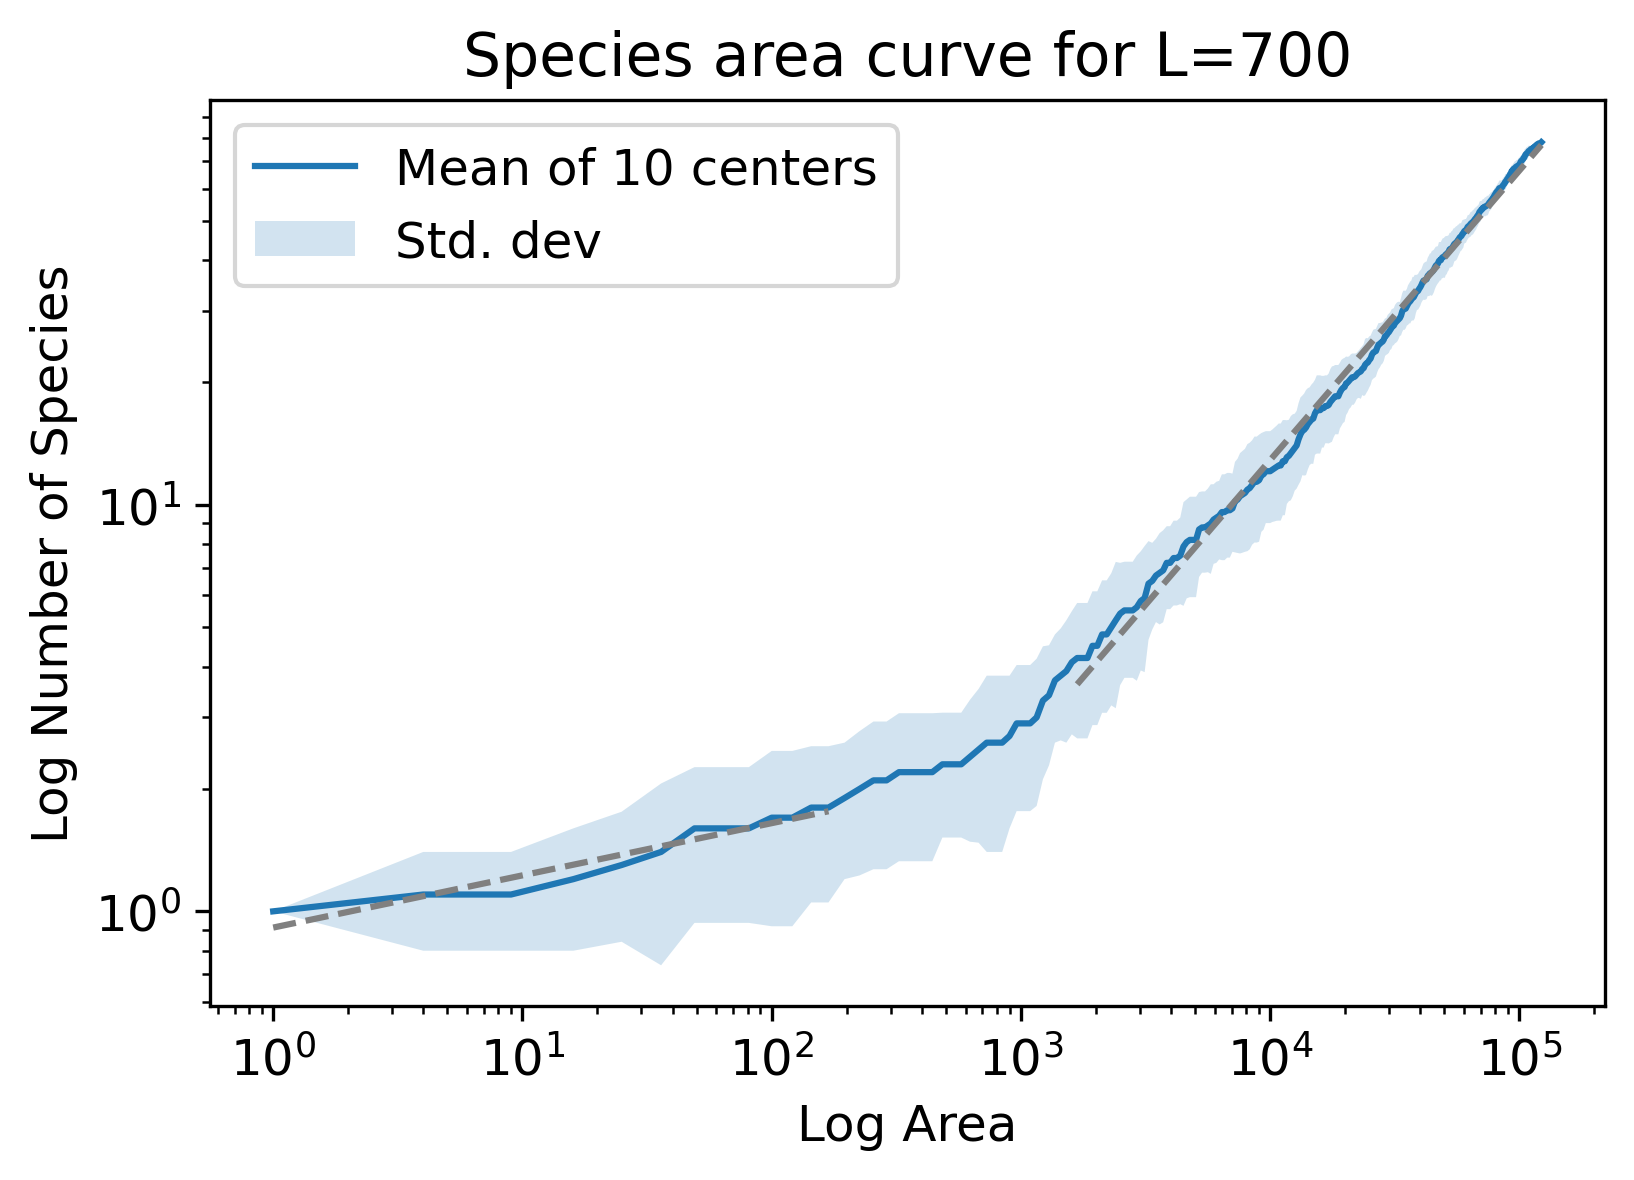

In [16]:
end_1 = 12
start_2 = 40
poly_coeffs_1 = np.polyfit(np.log(areas)[:end_1], np.log(spec_mean)[:end_1], 1)
poly_coeffs_2 = np.polyfit(np.log(areas)[start_2:], np.log(spec_mean)[start_2:], 1)

print(poly_coeffs_1[0], np.exp(poly_coeffs_1[1]))
print(poly_coeffs_2[0], np.exp(poly_coeffs_2[1]))

plt.loglog(areas, list(spec_mean), label='Mean of 10 centers')
plt.loglog([areas[0], areas[end_1]],
           np.exp(poly_coeffs_1[1])*np.array([areas[0], areas[end_1]])**poly_coeffs_1[0],
           linestyle='dashed',
           color='grey')

plt.loglog([areas[start_2], areas[-1]],
           np.exp(poly_coeffs_2[1])*np.array([areas[start_2], areas[-1]])**poly_coeffs_2[0],
           linestyle='dashed',
           color='grey')
plt.fill_between(areas, spec_mean-spec_std_dev, spec_mean+spec_std_dev, alpha=0.2, label='Std. dev')
plt.ylabel('Log Number of Species')
plt.xlabel('Log Area')
plt.title(f'Species area curve for L={700}')
plt.legend()
plt.show()